In [188]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [189]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthesh, neghold etc)
def isIncreasing(L):
    return L[0] < L[len(L) - 1]
def isDecreasing(L):
    return L[0] > L[len(L) - 1]
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sortIntoSide(voltage, current):
    if isIncreasing(voltage) and isIncreasing(current):
        return "posThresh"
    elif isDecreasing(voltage) and isDecreasing(current):
        return "posHold"
    elif isDecreasing(voltage) and isIncreasing(current):
        return "negThresh"
    elif isIncreasing(voltage) and isDecreasing(current):
        return "negHold"
    else: 
        print("???")

In [190]:
# this will take a file path and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_into_runs()
        self.sort_runs_into_neg_pos_thresh_hold()
        # self.sort_runs_into_neg_pos_thresh_hold()

        # print(self.device_temp, self.device_number, self.file_name)
        # self.graph_all_data()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'],sep='\t',skiprows=1)
        data = df5.values
        df5.head()
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)

        self.time = data[:,0]
        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]
        self.R = self.V / self.I

        self.dI = np.gradient(self.I)
        self.dTemps = np.gradient(self.temps)

        self.all_data = []

        for i in range(0, len(self.time)):
            self.all_data.append({
                'time': self.time[i],
                'I': self.I[i],
                'V': self.V[i],
                'temps': self.temps[i],
                'R': self.R[i],
                'dI': self.dI[i],
                'dTemps': self.dTemps[i]
            })


    def graph(self, x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title):
        plt.title(graph_title)
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(x_axis_data, y_axis_data)
        plt.xlabel(x_axis_title)
        plt.ylabel(y_axis_title)
        plt.figure(np.random.randint(1000000000))



    def graph_runs_data(self, start, stop):
        plt.title("runs: ", start, " - ", stop)
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        # print("Temp: " , self.temp[0] , " - " , self.temp[len(self.temp) - 1] , " K")
        # plt.text(-1.5, 0.01, "Temp: " + str(self.temp[1]) + " - " + str(self.temp[len(self.temp) - 1]) + " K", fontsize=12)
        # plt.text(-0.5, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.5, 0.01, "Sample: " + self.sample_number, fontsize=12)
        plt.semilogy(self.V[start:stop], self.I[start:stop])
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

    def break_into_runs(self):
        # self.max_v = np.amax(self.V)
        # self.min_v = np.amin(self.V)
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        self.V_in_runs = []
        self.all_data_in_runs = []
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = self.all_zero_indexes[i+1]
            self.V_in_runs.append(self.V[start:stop])

            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.V[start:stop])

            self.all_data_in_runs.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'dI': np.gradient(self.I[start:stop]),
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'dTemps': np.gradient(self.temps[start:stop]),
                'temp': run_temp,
                'temp_std': run_temp_std, 
                'R': self.R[start:stop],
            })

        self.number_of_runs = len(self.all_zero_indexes)
        print("number of IV curves: ", self.number_of_runs)

    def graph_IV_curve(self, run_to_graph):
        start = self.all_zero_indexes[run_to_graph]
        stop = self.all_zero_indexes[run_to_graph + 2]

        x_axis = self.V[start:stop]
        y_axis = self.I[start:stop]

        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(x_axis, y_axis)

        # sort into pos and neg
        # find thresh for pos and neg
        # find hold for hold for pos and neg


        pos_side = []
        neg_side = []

        # print(np.gradient())

        # for i in range(len(x_axis) - 1): 
        #     if (x_axis[i] > x_axis[i +1]):
        #         # print(i)
        #         neg_side.append(self.V[start:stop])
        #     else: 
        #         # print("neg")
        #         pos_side.append(self.V[start:stop])

        # neg_voltage_to_graph = self.neg_runs_gradient[run_to_graph]['V']
        # neg_current_to_graph = self.neg_runs_gradient[run_to_graph]['I']
        # neg_current_gradient_max_index = np.argmax(self.neg_runs_gradient[run_to_graph]['dI']) - 1
        # plt.plot(neg_voltage_to_graph[neg_current_gradient_max_index], neg_current_to_graph[neg_current_gradient_max_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
        # plt.semilogy(neg_voltage_to_graph, neg_current_to_graph)

        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))
    
    def sort_runs_into_neg_pos_thresh_hold(self):
        # self.pos_runs = []
        # self.neg_runs = []
        self.pos_thesh_runs = []
        self.pos_hold_runs = []
        self.neg_thresh_runs = []
        self.neg_hold_runs = []

        for run in self.all_data_in_runs:
            index_of_switch = np.argmax(np.absolute(run['V']))
            start = 0
            stop = index_of_switch
            end = len(run['V']) - 1

            print("start: ", sortIntoSide(run['V'][0:index_of_switch], run['I'][0:index_of_switch]))
            print("end: ", sortIntoSide(run['V'][index_of_switch:end], run['I'][index_of_switch:end]))

            type_of_data = sortIntoSide(run['V'][0:index_of_switch], run['I'][0:index_of_switch])

            if (type_of_data == "posThresh"):
                self.pos_thesh_runs.append(run)
            if (type_of_data == "posHold"):
                self.pos_hold_runs.append(run)
            if (type_of_data == "negThresh"):
                self.neg_thresh_runs.append(run)
            if (type_of_data == "negHold"):
                self.neg_hold_runs.append(run)

                
            # if (run['V'][3] > 0): # positive side
            #     if (run['V'][3] > 0)
            #     self.pos_thesh_runs.append({
            #         'time': self.time[start:stop],
            #         'I': self.I[start:stop],
            #         'V': self.V[start:stop],
            #         'temps': self.temps[start:stop],
            #         'dI': np.gradient(self.dI[start:stop]),
            #         'dTemps': np.gradient(self.dTemps[start:stop]),
            #         'R': self.R[start:stop],
            #         # 'temp': run_temp,
            #         # 'temp_std': run_temp_std
            #         })
            #     self.pos_hold_runs.append({
            #         'time': self.time[start:stop],
            #         'I': self.I[start:stop],
            #         'V': self.V[start:stop],
            #         'temps': self.temps[start:stop],
            #         'R': self.R[start:stop],
            #         # 'temp': run_temp,
            #         # 'temp_std': run_temp_std
            #         })
            # else:
            #     self.neg_thresh_runs.append({
            #         'time': self.time[start:stop],
            #         'I': self.I[start:stop],
            #         'V': self.V[start:stop],
            #         'temps': self.temps[start:stop],
            #         'R': self.R[start:stop],
            #         # 'temp': run_temp,
            #         # 'temp_std': run_temp_std
            #         })
            #     self.neg_hold_runs.append({
            #         'time': self.time[start:stop],
            #         'I': self.I[start:stop],
            #         'V': self.V[start:stop],
            #         'temps': self.temps[start:stop],
            #         'R': self.R[start:stop],
            #         # 'temp': run_temp,
            #         # 'temp_std': run_temp_std
            #         })
            #     # self.neg_runs.append(run)

        # self.calculate_gradient_all_data()

        # print(self.pos_hold_runs)

        

    

number of data points:  199347
number of IV curves:  1993
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThresh
end:  negHold
start:  posThresh
end:  posHold
start:  negThr

IndexError: list index out of range

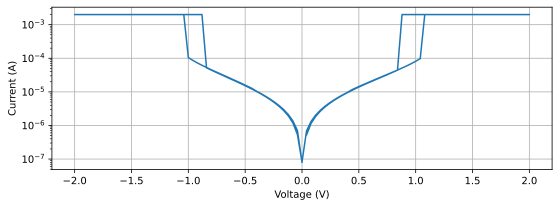

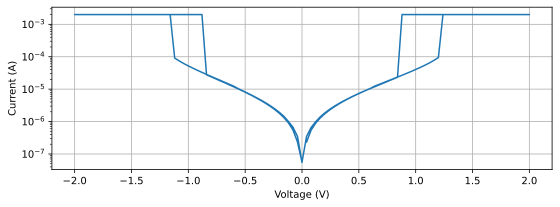

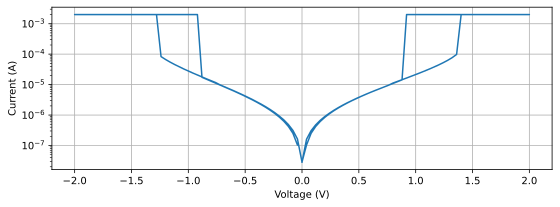

<Figure size 648x216 with 0 Axes>

In [191]:

theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042023_D18_try2edited.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042723_D18.txt");

# # current vs voltage
# x_axis_data = theFile.V
# y_axis_data = theFile.I
# x_axis_title = "Voltage (V)"
# y_axis_title = "Current (A)"
# graph_title = "Current vs Voltage"
# theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)


# # temp vs time
# x_axis_data = theFile.time
# y_axis_data = theFile.temps
# x_axis_title = "Time (s)"
# y_axis_title = "Temperature (K)"
# graph_title = "Temperature vs Time"
# theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)


# # resistance vs time
# x_axis_data = theFile.time
# y_axis_data = theFile.R
# x_axis_title = "Time (s)"
# y_axis_title = "Resistance (ohm)"
# graph_title = "Resistance vs Time"
# theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)


# # resistance vs time
# x_axis_data = theFile.temps
# y_axis_data = theFile.R
# x_axis_title = "Temperature (K)"
# y_axis_title = "Resistance (ohm)"
# graph_title = "Resistance vs Temperature"
# theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)


# current at specific temperature

# the graph will be the current at (0.2 +- 0.05) V vs Time
# voltages_to_graph = [0.2, 0.3, 0.4, 0.5]
# voltage_tolerance = 0.05

# for v in voltages_to_graph: 
#     # find all the indexes when current is (0.2 +- 0.05) V
#     voltage_to_graph_indexes = []
#     for x in range(len(theFile.time)):
#         if ((theFile.V[x] >= (v - voltage_tolerance) and theFile.V[x] <= (v + voltage_tolerance)) 
#         or (theFile.V[x] <= -(v - voltage_tolerance) and theFile.V[x] >= -(v + voltage_tolerance))):
#             voltage_to_graph_indexes.append(x)

#     x_axis_data = []
#     y_axis_data = []
#     for x in voltage_to_graph_indexes:
#         x_axis_data.append(theFile.time[x])
#         y_axis_data.append(theFile.I[x])

#     x_axis_title = "Time (s)"
#     y_axis_title = "Current (A)"
#     graph_title = "Current vs Time at " + str(v) + " V"
#     theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)


# theFile.graph_r_vs_temps()

# start = self.all_zero_indexes[run_to_graph]
# stop = self.all_zero_indexes[run_to_graph + 2]

# x_axis = self.V[start:stop]
# y_axis = self.I[start:stop]

# plt.rcParams['figure.figsize'] = (9,3)
# plt.grid()
# plt.semilogy(x_axis, y_axis)

# # neg_voltage_to_graph = self.neg_runs_gradient[run_to_graph]['V']
# # neg_current_to_graph = self.neg_runs_gradient[run_to_graph]['I']
# # neg_current_gradient_max_index = np.argmax(self.neg_runs_gradient[run_to_graph]['dI']) - 1
# # plt.plot(neg_voltage_to_graph[neg_current_gradient_max_index], neg_current_to_graph[neg_current_gradient_max_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# # plt.semilogy(neg_voltage_to_graph, neg_current_to_graph)

# plt.xlabel('Voltage (V)')
# plt.ylabel('Current (A)')
# plt.figure(np.random.randint(1000000000))


# for x in range(19):
for x in range(10,13):
  number_of_runs = theFile.number_of_runs / 1.75
  i = (int)((number_of_runs / 12) * x)
  theFile.graph_IV_curve(i)


# theFile.graph(neg_hold_runs[0])\

# resistance vs time
# print(theFile.neg_thresh_runs[2])
x_axis_data = theFile.neg_hold_runs[0]['V']
y_axis_data = theFile.neg_hold_runs[0]['I']
x_axis_title = "Voltage (X)"
y_axis_title = "Current (A)"
graph_title = "Voltage vs Current"
theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)

# # resistance vs time
# x_axis_data = theFile.neg_hold_runs[1]['V']
# y_axis_data = theFile.neg_hold_runs[1]['I']
# x_axis_title = "Voltage (X)"
# y_axis_title = "Current (A)"
# graph_title = "Voltage vs Current"
# theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)

# # resistance vs time
# x_axis_data = theFile.neg_hold_runs[2]['V']
# y_axis_data = theFile.neg_hold_runs[2]['I']
# x_axis_title = "Voltage (X)"
# y_axis_title = "Current (A)"
# graph_title = "Voltage vs Current"
# theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)

# # resistance vs time
# x_axis_data = theFile.neg_hold_runs[3]['V']
# y_axis_data = theFile.neg_hold_runs[3]['I']
# x_axis_title = "Voltage (X)"
# y_axis_title = "Current (A)"
# graph_title = "Voltage vs Current"
# theFile.graph(x_axis_data, y_axis_data, x_axis_title, y_axis_title, graph_title)



  